# PyTorch MNIST Basic Example

## Introduction

This tutorial focuses on how to train a CNN model with Fed-BioMed nodes using the PyTorch framework on the MNIST dataset. You will learn; 

- How to prepare your environment to be able to train your model;
- How to create a training plan class to run it in a single node which works as a different process in your local machine;
- How to create a federated learning experiment;
- How to load and inspect your model parameters;
- How to test your model using test dataset.

**Note:** In the following steps, we will be running this example using two nodes. 

## Before you start

Before starting this tutorial please change your directory where you want to keep created Fed-BioMed components. This will allow you to keep Fed-BioMed component in a specific folder, and will ease specifying components using `fedbiomed` command. 
 


## 1. Configuring Nodes 

In this tutorial, you will learn how to train your model with a single Fed-BioMed node. Thus, you need to configure a node and add MNIST dataset into it.
Please open a terminal and follow the steps below.    

* **Configuration Steps:**
    * Navigate to directory where you want to keep Fed-BioMed node and researcher component folders.
    * Run `fedbiomed node dataset add` in the terminal. This command will automatically create a default node component folder called 'fbm-node'.
    * It will ask you to select the data type that you want to add. The second option (which is the default) has been configured to add the MNIST dataset. Please type `2` and continue. 
    * Please use default tags which are `#MNIST` and `#dataset`.
    * For the next step, please select the directory that you want to download the MNIST dataset. Usually, we may want to save them into the node component folder (here in `fbm-node/data/` folder).
    * After the download is completed you will see the details of the MNIST dataset on the screen.
 
Please run the command below in the same terminal to make sure the MNIST dataset is successfully added to the node.  

```
$ fedbiomed node dataset list
```

Then launch the `Node` by executing:

```
$ fedbiomed node start
```

### Start your notebook

You need to start a jupyter notebook and create a new notebook to be able to follow the tutorial. Please open a new terminal window and run the following command to start your notebook.

```
$ fedbiomed researcher start
```

The command above will create a component folder for researcher called "fbm-researcher" in the directory where this command is executed.**Note:** If you are having a problem understanding the steps above, we recommend you to follow the [installation tutorial](../../installation/0-basic-software-installation).



## 2. What is MNIST dataset?

[MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains 60000 grayscale images (of size 28 * 28 pixels) of handwritten digits between 0 and 9. MNIST is commonly used for image classification task: the goal is to classify each image by assigning it to the correct digit. 

## 3. Training a model 

In this section, you will learn how to train a model in Fed-BioMed, by creating a training plan class that includes special methods to retrieve mode, optimizer, training data as well as training step to execute at each iteration of training. Then the federated training will be launched by wrapping the training plan in an experiment.


### 3.1 Creating A PyTorch Training Plan
A PyTorch training plan is a Python class that inherits from `fedbiomed.common.training_plans.TorchTrainingPlan` which is an abstract class. The abstract methods `init_model`, `training_data` and `training_step` should be provided in the training plan to retrieve/execute model (`nn.Module`), data loader and training actions at each iteration.

<div class="note">
    <p>
        Please visit <a href="../../../user-guide/researcher/training-plan/">training plan user guide</a> for more information and other special methods of training plan.
    </p>
</div>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.datamanager import DataManager
from torchvision import transforms
from fedbiomed.common.dataset import MnistDataset

# Here we define the training plan to be used.
# You can use any class name (here 'MyTrainingPlan')
class MyTrainingPlan(TorchTrainingPlan):
    class Net(nn.Module):
        def __init__(self, model_args):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 32, 3, 1)
            self.conv2 = nn.Conv2d(32, 64, 3, 1)
            self.dropout1 = nn.Dropout(0.25)
            self.dropout2 = nn.Dropout(0.5)
            self.fc1 = nn.Linear(9216, 128)
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = self.dropout1(x)
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.dropout2(x)
            x = self.fc2(x)
            output = F.log_softmax(x, dim=1)
            return output

    def init_model(self, model_args):
        return self.Net(model_args = model_args)

    def init_optimizer(self, optimizer_args):
        return Adam(self.model().parameters(), lr = optimizer_args["lr"])

    def init_dependencies(self):
        return ["from fedbiomed.common.dataset import MnistDataset",
                "from torchvision import transforms",
                "from torch.optim import Adam"]

    def training_data(self):
        transform = transforms.Normalize((0.1307,), (0.3081,))
        dataset1 = MnistDataset(transform=transform)
        loader_arguments = {'shuffle': True}
        return DataManager(dataset1, **loader_arguments)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss   = torch.nn.functional.nll_loss(output, target)
        return loss


<div class="note">
    <p>
        Fed-BioMed nodes can be configured to accept only approved training plans. Under this configuration, the training plan files that are sent by a researcher must be approved by the node in advance. For more details, you can visit the tutorial for <a href="../../security/training-with-approved-training-plans">working with approved training plan file</a> and <a href="../../../user-guide/nodes/training-plan-security-manager">user guide for managing nodes.</a>
    </p>
</div>

### 3.2 Define an Experiment
 
 An experiment is a class that orchestrates the training processes that run on different nodes.

 - `model_arg` includes arguments that will pass into `init_model` method of training plan class. In our case, we don't need to add any arguments.
 - `training_args` includes arguments related to optimizer, data loader and training step/routine such as learning rate, number of epochs.
 - `tags` is a list that includes tags that are going to be used for searching related datasets in nodes. In our case, we saved the MNIST dataset with #MNIST and #dataset tags.
 - `rounds` represents the number of training rounds that will be applied in nodes. In each round every node complete epochs and send model parameters to the experiment.

!!! note "Validation step on testing dataset"
    The training arguments can also include testing parameters to define how the trained model performs for both globally and locally updated model weights after local training. These parameters allow you to reserve a portion of the training dataset for validation. The node retains the initially selected validation subset and uses the same samples for subsequent training rounds. However, if `shuffle_testing_dataset` is set to true for a given round, the dataset will be reshuffled, creating a new validation subset. Additionally, modifying the test ratio will reset the testing dataset, leading to a newly selected validation set that differs from previous training rounds. For more information please visit [testing documentation](../../user-guide/researcher/model-testing-during-federated-training.md).


In [ ]:
from fedbiomed.common.metrics import MetricTypes
model_args = {}

training_args = {
    'loader_args': { 'batch_size': 48, },
    'optimizer_args': {
        'lr': 1e-3
    },
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100, # Fast pass for development : only use ( batch_maxnum * batch_size ) samples,
    'test_ratio' : 0.25,
    'test_metric': MetricTypes.F1_SCORE,
    'test_on_global_updates': True,
    'test_on_local_updates': True,
    'test_batch_size': 0,
    'shuffle_testing_dataset': True,
}

tags =  ['#MNIST', '#dataset']
rounds = 4


Training plan class should be passed to the experiment. The experiment will be responsible for uploading the training plan file to the file repository. Afterwards, the nodes will receive training request that includes the URL where the training plan class is stored.

Finally, you should indicate which method should be chosen to aggregate model parameters after every round. The basic federation scheme is federated averaging, implemented in Fed-BioMed in the class  `FedAverage`.

### 3.3 What happens during the initialization of an experiment?

1. The experiment searches for `Nodes` whose available datasets have been saved with tags indicated in the `tags` argument. Nodes are selected based on a node selection strategy.
2. The experiment sets up according to the provided arguments

For more details, you can visit [`Experiment` webpage](../../../user-guide/researcher/experiment).

Now, let's create our experiment. Since only one node has been created, the experiment will only find a single node for training. 

In [ ]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage


exp = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

As an output, you should see the log message from the node which dispose of the MNIST dataset. It means that the search request that contains `#MNIST, #dataset` tags has been successfully received by the node. In the example displayed here, we received messages only from one `Node`, which we created before. *Obviously, it is non-sensical to train a `Federated Learning` model with only one `Node`, but this tutorial is just here for the sake of demonstration.* 

The experiment also receives loss values during training on each node. In Fed-BioMed, it is possible to use a tensorboard to display loss values during training. Please refer to Fed-BioMed's [tensorboard documentation](../../../user-guide/researcher/tensorboard) for how to enable the tensorboard.

Now, let's run the experiment.

In [ ]:
exp.run()

Save trained model to file

In [ ]:
exp.training_plan().export_model('./trained_model')

After running the experiment, according to the provided arguments 4 training rounds should be completed on the node that you created. You can check the node id from the output and compare it with the node id which is defined in the config.ini file. After the process is finished, you are ready to inspect the model parameters. 

### 3.4 Extracting Training Results

#### Timing 

Training replies for each round are available via `exp.training_replies()` (index 0 to (`rounds` - 1) ). You can display the keys of each round by running the following script. 

In [ ]:
print("\nList the training rounds : ", exp.training_replies().keys())

Now, let's see how training details can be accessed from `training_replies()`. The following parameters will be inspected;

- `rtime_training` : Real-time (clock time) spent in the training function on the node 
- `ptime_training`: Process time (user and system CPU) spent in the training function on the node
- `rtime_total`   : Real-time (clock time) spent in the researcher between sending training requests and handling the responses

_Note: The following code accesses the training replies of the last round of the experiment._

In [ ]:
print("\nList the training rounds : ", exp.training_replies().keys())

print("\nList the nodes for the last training round and their timings : ")
round_data = exp.training_replies()[rounds - 1]
for r in round_data.values():
    print("\t- {id} :\
    \n\t\trtime_training={rtraining:.2f} seconds\
    \n\t\tptime_training={ptraining:.2f} seconds\
    \n\t\trtime_total={rtotal:.2f} seconds".format(id = r['node_id'],
        rtraining = r['timing']['rtime_training'],
        ptraining = r['timing']['ptime_training'],
        rtotal = r['timing']['rtime_total']))

#### Federated Parameters
Federated model parameters for each round are available via `exp.aggregated_params()` (index 0 to (`rounds` - 1) ).
For example, you can easily view the federated parameters for the last round of the experiment:

In [ ]:
print("\nAccess the federated params for the last training round : ")
print("\t- parameter data: ", exp.aggregated_params()[rounds - 1]['params'].keys())


Finally, to access specific parameters of last round:

In [ ]:
print("\t- Parameters of CONV1 layer's biases of last round: \n", exp.aggregated_params()[rounds - 1]['params']['conv1.bias'])

In [ ]:
# access the TrainingPlan
exp.training_plan()

## 4. PyTorch MNIST Example with Two Nodes

In this section, we will be working on two nodes. Following the previous example, the experiment and training routine will remain unchanged.  Therefore, you just need to configure another node, and add the MNIST dataset with the default tags.

### 4.1 Configuring Second Node

While creating a second node you need to be careful with the node that has already been created. To configure the second node, a different config file has to be defined. Please follow the steps below to configure your second node. 

1. Please open a new terminal and cd into the base directory of fedbiomed.
2. In this step, you need to name a new config file using the `--path` parameter. Instead of downloading a new MNIST dataset, you can use the one that you already downloaded in the previous example. To do so please run `fedbiomed node --path ./my-second-node dataset add --mnist /path/to/your/mnist`. Otherwise you can still do a `fedbiomed node --path ./my-second-node dataset add` as shown before. It will create a component directory called `my-second-node` in the directory where the command is executed.
3. You need to start the new node by indicating the newely created config file. Please run the following command to start the second node `fedbiomed node --path ./my-second-node start`

### 4.2 Defining an Experiment 

Since a training plan has already been created and saved in the previous example, you don't need to repeat this step here again: the same training plan with same model will be used for training. However, you can define a new experiment for testing purposes. The experiment will search the MNIST dataset in available nodes. Training arguments are kept the same as in the previous example.

_You can also list datasets and select specific nodes to perform training. You can visit [listing datasets and selecting nodes](../../../user-guide/researcher/listing-datasets-and-selecting-nodes) documentation to get more information._

In [ ]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

model_args = {}

training_args = {
    'loader_args': { 'batch_size': 48, },
    'optimizer_args': {
        'lr': 1e-3
    },
    'epochs': 1,
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['#MNIST', '#dataset']
rounds = 4

expN2 = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

You can see from the output that the search request (done when initializing `Experiment`) has been sent to 2 `Nodes` by the experiment.

Now, let's run the experiment. 

In [ ]:
expN2.run()

## 5. Testing Federated Model

In this section, we will create a test function to obtain accuracy, loss, and confusion matrix using the test MNIST dataset. 

### 5.1 Aggregated Parameters 

`training_plan()` returns the training plan and `training_plan().model()` returns the model that is created in the training plan.  It is possible to load specific aggregated parameters which are obtained in every round. Thereafter, it will be ready to make predictions using those parameters. The last round gives the last aggregated model parameters which represents the final model.

In [ ]:
fed_model = expN2.training_plan().model()
fed_model.load_state_dict(expN2.aggregated_params()[rounds - 1]['params'])

### 5.2 Creating A Test Function

Let's create a test function that returns loss, accuracy, and confusion matrix. 

In [ ]:
import pandas as pd
import torch.nn.functional as F
# Test function 
def testing_accuracy(model, data_loader,):
    model.eval()
    test_loss = 0
    device = 'cpu'

    y_pred = []
    y_actu = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            y_pred.extend(torch.flatten(pred).tolist()) 
            y_actu.extend(target.tolist())
           
    y_pred = pd.Series(y_pred, name='Actual')
    y_actu = pd.Series(y_actu, name='Predicted')
    cm = pd.crosstab(y_actu, y_pred)
    correct = sum([cm.iloc[i,i] for i in range(len(cm))])
    
    test_loss /= len(data_loader.dataset)
    accuracy = 100*correct/len(data_loader.dataset)

    return(test_loss, accuracy, cm)

We will use the MNIST test dataset for testing our federated model. To do this, we will use the complete_initialization function, which is normally done under the hood in Fedbiomed. As a user, one does not need to call this function directly, but here we will show it as an alternative way to initialize your data. This function transmits the parameters of the called Dataset, which for Mnist are:

- `root: `     The path of the dataset.
- `train:`     Whether to use the training or the testing data of MNIST.
- `download: ` Whether to download the dataset or not. (In this example no, as we have already downloaded the data).

These parameters are transmitted via the dictionary `controller_kwargs`. The function also requires us to specify the return format, which is an enum of `DataReturnFormat.SKLEARN` and `DataReturnFormat.TORCH`.

In [ ]:
import torch
from torchvision import datasets, transforms
from fedbiomed.common.dataset_types import DataReturnFormat
import os


transform = transforms.Normalize((0.1307,), (0.3081,))
path = '<path-to-mnist>'

# Get the test dataset
# here we save the dataset under the `tmp` directory within Fed-BioMed folder
test_set = MnistDataset(transform=transform)
test_set.complete_initialization(controller_kwargs={'root':os.path.abspath(path), 'train':False}, to_format=DataReturnFormat.TORCH)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Now, it is time to get performance results

In [ ]:
test_results = testing_accuracy(fed_model, test_loader)

print("- Test Loss: ", test_results[0], "\n")
print("- Accuracy: ", test_results[1], "\n")
print("- Confusion Matrix: \n \n",  test_results[2] )

### 5.3 Creating Heatmap for Confusion Matrix

We will use `matplotlib` for plotting results. If you have followed all the steps in this tutorial, you must have installed this library in the section 2. Otherwise, you can run `!pip install matplotlib` command in a notebook cell.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

conf_matrix = test_results[2].to_numpy()

fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(conf_matrix)

ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="w")
        
ax.set_xlabel('Actual targets')
ax.set_ylabel('Predicted targets')
ax.set_title('Confusion Matrix')

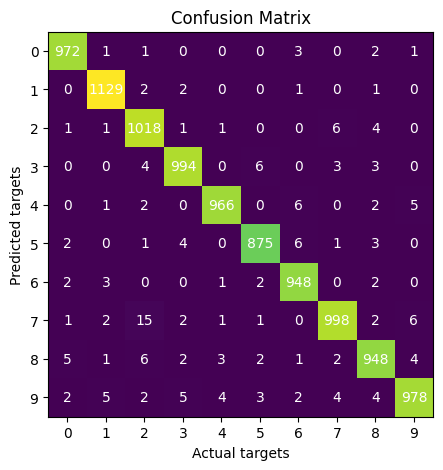

### 5.4 Plotting Loss for Each round
In this section, we will plot loss values that are obtained over the test dataset using model parameters of every round.

In [ ]:
errors = []

for i in range(rounds):
    fed_model = expN2.training_plan().model()
    fed_model.load_state_dict(expN2.aggregated_params()[i]['params'])
    loss = testing_accuracy(fed_model, test_loader)[0]
    errors.append(loss)

In [ ]:
### Plotting 
plt.plot(errors, label = 'Federated Test Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title("Log Likelihood Loss evolution over number of rounds")
plt.legend()

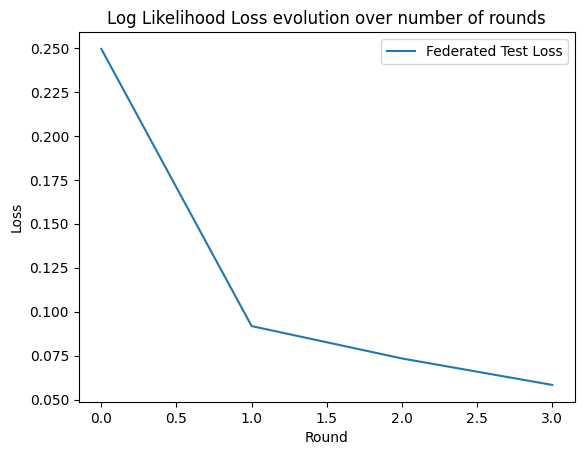